# ArangoDB DGL Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/dgl-adapter/blob/2.0.0/examples/ArangoDB_DGL_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://raw.githubusercontent.com/arangoml/dgl-adapter/master/examples/assets/adb_logo.png)
<img src="https://raw.githubusercontent.com/arangoml/dgl-adapter/master/examples/assets/dgl_logo.png" width=40% />

Version: 2.0.0

Objective: Export Graphs from [ArangoDB](https://www.arangodb.com/), a multi-model Graph Database, to [Deep Graph Library](https://www.dgl.ai/) (DGL), a python package for graph neural networks, and vice-versa.

# Setup

In [ ]:
%%capture
!pip install adbdgl-adapter==2.0.0
!pip install adb-cloud-connector
!git clone -b 2.0.0 --single-branch https://github.com/arangoml/dgl-adapter.git

## For drawing purposes 
!pip install matplotlib
!pip install networkx 

In [2]:
# All imports

import dgl
from dgl import remove_self_loop
from dgl.data import MiniGCDataset
from dgl.data import KarateClubDataset

import torch
from torch import Tensor

from adbdgl_adapter import ADBDGL_Adapter, ADBDGL_Controller
from adbdgl_adapter.typings import Json, ArangoMetagraph, DGLCanonicalEType, DGLDataDict

from arango import ArangoClient
from adb_cloud_connector import get_temp_credentials

import json
import logging

import matplotlib.pyplot as plt
import networkx as nx

# Understanding DGL

(referenced from [docs.dgl.ai](https://docs.dgl.ai/en/0.6.x/))


Deep Graph Library (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting **PyTorch**, **MXNet** and **TensorFlow**).

DGL represents a directed graph as a `DGLGraph` object. You can construct a graph by specifying the number of nodes in the graph as well as the list of source and destination nodes. **Nodes in the graph have consecutive IDs starting from 0.**

The following code constructs a directed "star" homogeneous graph with 6 nodes and 5 edges. 


In [14]:
# A homogeneous graph with 6 nodes, and 5 edges
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
print(g)

# Print the graph's canonical edge types
print("\nCanonical Edge Types: ", g.canonical_etypes)
# >>> [('_N', '_E', '_N')]
# '_N' being the only Node type
# '_E' being the only Edge type

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={}
      edata_schemes={})

Canonical Edge Types:  [('_N', '_E', '_N')]



In DGL, a heterogeneous graph (heterograph for short) is specified with a series of graphs as below, one per relation. Each relation is a string triplet `(source node type, edge type, destination node type)`. Since relations disambiguate the edge types, DGL calls them canonical edge types:

In [15]:
# A heterogeneous graph with 8 nodes, and 7 edges
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

print(g)
print("\nCanonical Edge Types: ", g.canonical_etypes)
print("\nNode Types: ", g.ntypes)
print("\nEdge Types: ", g.etypes)

Graph(num_nodes={'game': 4, 'user': 4},
      num_edges={('user', 'follows', 'game'): 3, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'game', 'follows'), ('user', 'game', 'plays'), ('user', 'user', 'follows')])

Canonical Edge Types:  [('user', 'follows', 'game'), ('user', 'follows', 'user'), ('user', 'plays', 'game')]

Node Types:  ['game', 'user']

Edge Types:  ['follows', 'follows', 'plays']


Many graph data contain attributes on nodes and edges. Although the types of node and edge attributes can be arbitrary in real world, **DGLGraph only accepts attributes stored in tensors** (with numerical contents). Consequently, an attribute of all the nodes or edges must have the same shape. In the context of deep learning, those attributes are often called features.

You can assign and retrieve node and edge features via ndata and edata interface.

In [16]:
# A homogeneous graph with 6 nodes, and 5 edges
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

# Assign an integer value for each node.
g.ndata['x'] = torch.tensor([151, 124, 41, 89, 76, 55])
# Assign a 4-dimensional edge feature vector for each edge.
g.edata['a'] = torch.randn(5, 4)

print(g)
print("\nNode Data X attribute: ", g.ndata['x'])
print("\nEdge Data A attribute: ", g.edata['a'])


# NOTE: The following line ndata insertion will fail, since not all nodes have been assigned an attribute value
# g.ndata['bad_attribute'] = torch.tensor([0,10,20,30,40])

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})

Node Data X attribute:  tensor([151, 124,  41,  89,  76,  55])

Edge Data A attribute:  tensor([[-0.6538,  1.5450, -1.7828,  1.2241],
        [ 1.3176, -0.0545,  0.8196,  0.0695],
        [-0.8568,  1.3135,  0.4980, -0.4290],
        [ 1.5448,  0.2502,  2.3616,  1.2318],
        [-0.9194,  0.2285,  0.0267, -0.0482]])


When multiple node/edge types are introduced, users need to specify the particular node/edge type when invoking a DGLGraph API for type-specific information. In addition, nodes/edges of different types have separate IDs.

In [17]:
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

# Get the number of all nodes in the graph
print("All nodes: ", g.num_nodes())

# Get the number of user nodes
print("User nodes: ", g.num_nodes('user'))

# Nodes of different types have separate IDs,
# hence not well-defined without a type specified
# print(g.nodes())
#DGLError: Node type name must be specified if there are more than one node types.

print(g.nodes('user'))

All nodes:  8
User nodes:  4
tensor([0, 1, 2, 3])


To set/get features for a specific node/edge type, DGL provides two new types of syntax – g.nodes[‘node_type’].data[‘feat_name’] and g.edges[‘edge_type’].data[‘feat_name’].

**Note:** If the graph only has one node/edge type, there is no need to specify the node/edge type.

In [18]:
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

g.nodes['user'].data['age'] = torch.tensor([21, 16, 38, 64])
# An alternative (yet equivalent) syntax:
# g.ndata['age'] = {'user': torch.tensor([21, 16, 38, 64])}

print(g.ndata)

defaultdict(<class 'dict'>, {'age': {'user': tensor([21, 16, 38, 64])}})


For more info, visit https://docs.dgl.ai/en/0.6.x/. 

# Create a Temporary ArangoDB Cloud Instance

In [3]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(con["dbName"], con["username"], con["password"], verify=True)

Log: requesting new credentials...
Succcess: new credentials acquired
{
  "dbName": "TUT56z6dbtgsoeu5cc6aixs7d",
  "username": "TUTtj3263blez70kmqdi3ts",
  "password": "TUTf6tursgxqogdo3ww3nplb",
  "hostname": "tutorials.arangodb.cloud",
  "port": 8529,
  "url": "https://tutorials.arangodb.cloud:8529"
}


Feel free to use to above URL to checkout the UI!

# Data Import

For demo purposes, we will be using the [ArangoDB Fraud Detection example graph](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Fraud_Detection.ipynb).

In [4]:
!chmod -R 755 dgl-adapter/
!./dgl-adapter/tests/assets/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "dgl-adapter/examples/data/fraud_dump" --include-system-collections true

2022-05-25T17:23:07Z [272] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://tutorials.arangodb.cloud:8529'
2022-05-25T17:23:08Z [272] INFO [abeb4] {restore} Database name in source dump is 'fraud-detection'
2022-05-25T17:23:08Z [272] INFO [9b414] {restore} # Re-creating document collection '_analyzers'...
2022-05-25T17:23:08Z [272] INFO [9b414] {restore} # Re-creating document collection '_appbundles'...
2022-05-25T17:23:12Z [272] INFO [9b414] {restore} # Re-creating document collection '_apps'...
2022-05-25T17:23:13Z [272] INFO [9b414] {restore} # Re-creating document collection '_aqlfunctions'...
2022-05-25T17:23:17Z [272] INFO [9b414] {restore} # Re-creating document collection '_graphs'...
2022-05-25T17:23:17Z [272] INFO [9b414] {restore} # Re-creating document collection '_modules'...
2022-05-25T17:23:17Z [272] INFO [9b414] {restore} # Re-creating document collection 'account'...
2022-05-25T17:23:18Z [272] INFO [9b414] {restore} # Re-creating document collection 'bank'...


# Instantiate the Adapter

Connect the ArangoDB-DGL Adapter to our temporary ArangoDB cluster:

In [5]:
adbdgl_adapter = ADBDGL_Adapter(db)

[2022/05/25 17:23:34 +0000] [60] [INFO] - adbdgl_adapter: Instantiated ADBDGL_Adapter with database 'TUT56z6dbtgsoeu5cc6aixs7d'


# <u>ArangoDB to DGL</u>



#### Via ArangoDB Graph

Data source
* ArangoDB Fraud-Detection Graph

Package methods used
* [`adbdgl_adapter.adapter.arangodb_graph_to_dgl()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L198-L213)

Important notes
* The `name` parameter in this case must point to an existing ArangoDB graph in your ArangoDB instance. 

In [6]:
# Define graph name
graph_name = "fraud-detection"

# Create DGL graph from ArangoDB graph
dgl_g = adbdgl_adapter.arangodb_graph_to_dgl(graph_name)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# dgl_g = aadbdgl_adapter.arangodb_graph_to_dgl(graph_name, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(dgl_g)
print(dgl_g.ntypes)
print(dgl_g.etypes)

[2022/05/25 17:23:40 +0000] [60] [INFO] - adbdgl_adapter: Created DGL 'fraud-detection' Graph



--------------------
Graph(num_nodes={'account': 54, 'customer': 17},
      num_edges={('account', 'accountHolder', 'customer'): 54, ('account', 'transaction', 'account'): 62},
      metagraph=[('account', 'customer', 'accountHolder'), ('account', 'account', 'transaction')])
['account', 'customer']
['accountHolder', 'transaction']


#### Via ArangoDB Collections

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbdgl_adapter.adapter.arangodb_collections_to_dgl()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L169-L196)

Important notes
* The `name` parameter in this case is simply for naming your DGL graph.
* The `vertex_collections` & `edge_collections` parameters must point to existing ArangoDB collections within your ArangoDB instance.

In [7]:
# Define collection names
vertex_collections = {"account", "Class", "customer"}
edge_collections = {"accountHolder", "Relationship", "transaction"}

# Create DGL from ArangoDB collections
dgl_g = adbdgl_adapter.arangodb_collections_to_dgl("fraud-detection", vertex_collections, edge_collections)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# dgl_g = adbdgl_adapter.arangodb_collections_to_dgl("fraud-detection", vertex_collections, edge_collections, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(dgl_g)
print(dgl_g.ntypes)
print(dgl_g.etypes)

[2022/05/25 17:23:46 +0000] [60] [INFO] - adbdgl_adapter: Created DGL 'fraud-detection' Graph



--------------------
Graph(num_nodes={'Class': 4, 'account': 54, 'customer': 17},
      num_edges={('Class', 'Relationship', 'Class'): 4, ('account', 'accountHolder', 'customer'): 54, ('account', 'transaction', 'account'): 62},
      metagraph=[('Class', 'Class', 'Relationship'), ('account', 'customer', 'accountHolder'), ('account', 'account', 'transaction')])
['Class', 'account', 'customer']
['Relationship', 'accountHolder', 'transaction']


#### Via ArangoDB Metagraph

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbdgl_adapter.adapter.arangodb_to_dgl()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L70-L167)

Important notes
* The `name` parameter in this case is simply for naming your DGL graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.

In [8]:
# Define Metagraph
fraud_detection_metagraph = {
    "vertexCollections": {
        "account": {"rank", "Balance", "customer_id"},
        "Class": {"concrete"},
        "customer": {"rank"},
    },
    "edgeCollections": {
        "accountHolder": {},
        "Relationship": {},
        "transaction": {"receiver_bank_id", "sender_bank_id", "transaction_amt"},
    },
}

# Create DGL Graph from attributes
dgl_g = adbdgl_adapter.arangodb_to_dgl('FraudDetection',  fraud_detection_metagraph)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# dgl_g = adbdgl_adapter.arangodb_to_dgl(graph_name = 'FraudDetection',  fraud_detection_metagraph, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------')
print(dgl_g)
print('\n--------------')
print(dgl_g.ndata)
print('--------------\n')
print(dgl_g.edata)

[2022/05/25 17:23:50 +0000] [60] [INFO] - adbdgl_adapter: Created DGL 'FraudDetection' Graph



--------------
Graph(num_nodes={'Class': 4, 'account': 54, 'customer': 17},
      num_edges={('Class', 'Relationship', 'Class'): 4, ('account', 'accountHolder', 'customer'): 54, ('account', 'transaction', 'account'): 62},
      metagraph=[('Class', 'Class', 'Relationship'), ('account', 'customer', 'accountHolder'), ('account', 'account', 'transaction')])

--------------
defaultdict(<class 'dict'>, {'concrete': {'Class': tensor([True, True, True, True])}, 'customer_id': {'account': tensor([10000009, 10000004, 10000004, 10000010, 10000002, 10000011, 10000015,
        10000006, 10000010,    10810, 10000002, 10000014, 10000008,        0,
        10000002,        0, 10000008, 10000006, 10000012, 10000015, 10000001,
        10000010, 10000015, 10000005, 10000009, 10000008, 10000011, 10000014,
        10000010, 10000006, 10000002, 10000007, 10000006, 10000005,        0,
        10000010,    10810,        0, 10000009, 10000006, 10000002, 10000005,
        10000009, 10000012, 10000007, 1000000

#### Via ArangoDB Metagraph with a custom controller and verbose logging

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbdgl_adapter.adapter.arangodb_to_dgl()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L70-L167)
* [`adbdgl_adapter.controller._adb_attribute_to_dgl_feature()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/controller.py#L21-L47)

Important notes
* The `name` parameter in this case is simply for naming your DGL graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.
* We are creating a custom `ADBDGL_Controller` to specify *how* to convert our ArangoDB vertex/edge attributes into DGL node/edge features. View the default `ADBDGL_Controller` [here](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/controller.py#L11).

In [9]:
# Define Metagraph
fraud_detection_metagraph = {
    "vertexCollections": {
        "account": {"rank"},
        "Class": {"concrete", "name"},
        "customer": {"Sex", "Ssn", "rank"},
    },
    "edgeCollections": {
        "accountHolder": {},
        "Relationship": {},
        "transaction": {"receiver_bank_id", "sender_bank_id", "transaction_amt", "transaction_date", "trans_time"},
    },
}

# A user-defined Controller class is REQUIRED when converting non-numerical
# ArangoDB attributes to DGL features.
class FraudDetection_ADBDGL_Controller(ADBDGL_Controller):
    """ArangoDB-DGL controller.

    Responsible for controlling how ArangoDB attributes
    are converted into DGL features, and vice-versa.

    You can derive your own custom ADBDGL_Controller if you want to maintain
    consistency between your ArangoDB attributes & your DGL features.
    """

    def _adb_attribute_to_dgl_feature(self, key: str, col: str, val):
        """
        Given an ArangoDB attribute key, its assigned value (for an arbitrary document),
        and the collection it belongs to, convert it to a valid
        DGL feature: https://docs.dgl.ai/en/0.6.x/guide/graph-feature.html.

        NOTE: You must override this function if you want to transfer non-numerical
        ArangoDB attributes to DGL (DGL only accepts 'attributes' (a.k.a features)
        of numerical types). Read more about DGL features here:
        https://docs.dgl.ai/en/0.6.x/new-tutorial/2_dglgraph.html#assigning-node-and-edge-features-to-graph.

        :param key: The ArangoDB attribute key name
        :type key: str
        :param col: The ArangoDB collection of the ArangoDB document.
        :type col: str
        :param val: The assigned attribute value of the ArangoDB document.
        :type val: Any
        :return: The attribute's representation as a DGL Feature
        :rtype: Any
        """
        try:
          if col == "transaction":
            if key == "transaction_date":
              return int(str(val).replace("-", ""))
    
            if key == "trans_time":
              return int(str(val).replace(":", ""))
    
          if col == "customer":
            if key == "Sex":
              return {
                  "M": 0,
                  "F": 1
              }.get(val, -1)

            if key == "Ssn":
              return int(str(val).replace("-", ""))

          if col == "Class":
            if key == "name":
              return {
                  "Bank": 0,
                  "Branch": 1,
                  "Account": 2,
                  "Customer": 3
              }.get(val, -1)

        except (ValueError, TypeError, SyntaxError):
          return 0

        # Rely on the parent Controller as a final measure
        return super()._adb_attribute_to_dgl_feature(key, col, val)

# Instantiate the new adapter
fraud_adbdgl_adapter = ADBDGL_Adapter(db, FraudDetection_ADBDGL_Controller())

# You can also change the adapter's logging level for access to 
# silent, regular, or verbose logging (logging.WARNING, logging.INFO, logging.DEBUG)
fraud_adbdgl_adapter.set_logging(logging.DEBUG) # verbose logging

# Create DGL Graph from attributes
dgl_g = fraud_adbdgl_adapter.arangodb_to_dgl('FraudDetection',  fraud_detection_metagraph)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# dgl_g = fraud_adbdgl_adapter.arangodb_to_dgl(graph_name = 'FraudDetection',  fraud_detection_metagraph, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------')
print(dgl_g)
print('\n--------------')
print(dgl_g.ndata)
print('--------------\n')
print(dgl_g.edata)

[2022/05/25 17:23:56 +0000] [60] [INFO] - adbdgl_adapter: Instantiated ADBDGL_Adapter with database 'TUT56z6dbtgsoeu5cc6aixs7d'
[2022/05/25 17:23:56 +0000] [60] [DEBUG] - adbdgl_adapter: Starting arangodb_to_dgl(FraudDetection, ...):
[2022/05/25 17:23:56 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'account' vertices
[2022/05/25 17:23:56 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'Class' vertices
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'customer' vertices
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'accountHolder' edges
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'Relationship' edges
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 'transaction' edges
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'FraudDetection' homogenous? False
[2022/05/25 17:23:57 +0000] [60] [DEBUG] - adbdgl_adapter: Inserting 54 'rank' features into 'account'
[2022/05/25 17:23:57 +0000]


--------------
Graph(num_nodes={'Class': 4, 'account': 54, 'customer': 17},
      num_edges={('Class', 'Relationship', 'Class'): 4, ('account', 'accountHolder', 'customer'): 54, ('account', 'transaction', 'account'): 62},
      metagraph=[('Class', 'Class', 'Relationship'), ('account', 'customer', 'accountHolder'), ('account', 'account', 'transaction')])

--------------
defaultdict(<class 'dict'>, {'name': {'Class': tensor([0, 1, 2, 3])}, 'concrete': {'Class': tensor([True, True, True, True])}, 'rank': {'account': tensor([0.0021, 0.0031, 0.0052, 0.0021, 0.0046, 0.0037, 0.0032, 0.0042, 0.0021,
        0.0021, 0.0030, 0.0037, 0.0040, 0.0037, 0.0021, 0.0046, 0.0040, 0.0030,
        0.0026, 0.0032, 0.0021, 0.0034, 0.0032, 0.0021, 0.0021, 0.0035, 0.0026,
        0.0026, 0.0046, 0.0021, 0.0021, 0.0035, 0.0036, 0.0036, 0.0038, 0.0055,
        0.0021, 0.0041, 0.0044, 0.0021, 0.0030, 0.0035, 0.0033, 0.0026, 0.0071,
        0.0036, 0.0032, 0.0059, 0.0021, 0.0090, 0.0057, 0.0032, 0.0026, 0.0021]

# <u>DGL to ArangoDB</u>

#### Karate Graph

Data source
* [DGL Karate Graph](https://docs.dgl.ai/en/0.6.x/api/python/dgl.data.html#karate-club-dataset)

Package methods used
* [`adbdgl_adapter.adapter.dgl_to_arangodb()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L215-L311)

Important notes
* The `name` parameter in this case is simply for naming your ArangoDB graph.

[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Starting dgl_to_arangodb(Karate, ...):
[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'Karate' using default canonical_etypes? True
[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'Karate' homogenous? True
[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 34 'Karate_N' DGL nodes
[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 156 'Karate_E' DGL edges
[2022/05/25 17:24:04 +0000] [60] [DEBUG] - adbdgl_adapter: Inserting last 34 documents into 'Karate_N'
[2022/05/25 17:24:05 +0000] [60] [DEBUG] - adbdgl_adapter: Inserting last 156 documents into 'Karate_E'
[2022/05/25 17:24:05 +0000] [60] [INFO] - adbdgl_adapter: Created ArangoDB 'Karate' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTtj3263blez70kmqdi3ts
Password: TUTf6tursgxqogdo3ww3nplb
Database: TUT56z6dbtgsoeu5cc6aixs7d
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Karate


View the original graph below:



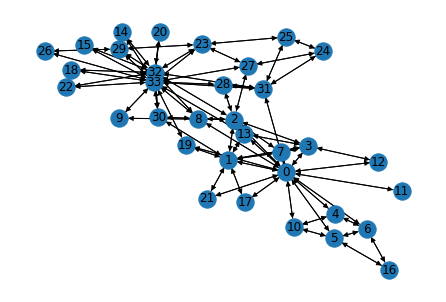

In [10]:
# Create the DGL graph & draw it
dgl_karate_graph = KarateClubDataset()[0]
nx.draw(dgl_karate_graph.to_networkx(), with_labels=True)

name = "Karate"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
adb_karate_graph = adbdgl_adapter.dgl_to_arangodb(name, dgl_karate_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")


#### MiniGCDataset Graphs

Data source
* [DGL Mini Graph Classification Dataset](https://docs.dgl.ai/en/0.6.x/api/python/dgl.data.html#mini-graph-classification-dataset)

Package methods used
* [`adbdgl_adapter.adapter.dgl_to_arangodb()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L215-L311)

Important notes
* The `name` parameters in this case are simply for naming your ArangoDB graph.

[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Starting dgl_to_arangodb(Lollipop, ...):
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'Lollipop' using default canonical_etypes? True
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'Lollipop' homogenous? True
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 7 'Lollipop_N' DGL nodes
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Preparing 24 'Lollipop_E' DGL edges
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Inserting last 7 documents into 'Lollipop_N'
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Inserting last 24 documents into 'Lollipop_E'
[2022/05/25 17:24:48 +0000] [60] [INFO] - adbdgl_adapter: Created ArangoDB 'Lollipop' Graph
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Starting dgl_to_arangodb(Hypercube, ...):
[2022/05/25 17:24:48 +0000] [60] [DEBUG] - adbdgl_adapter: Is graph 'Hypercube' using default can


--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTtj3263blez70kmqdi3ts
Password: TUTf6tursgxqogdo3ww3nplb
Database: TUT56z6dbtgsoeu5cc6aixs7d
--------------------

\View the created graphs here:

1) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Lollipop
2) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Hypercube
3) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Clique

View the original graphs below:



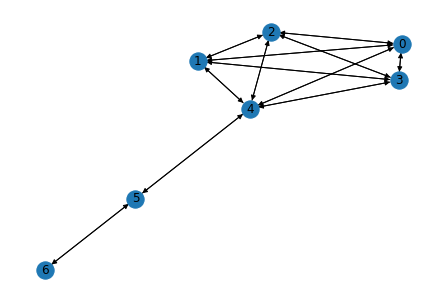

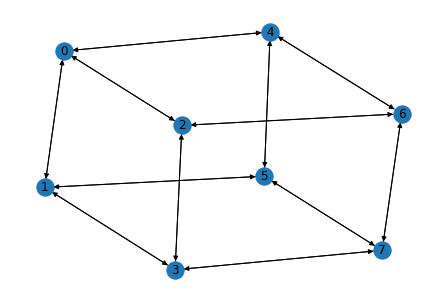

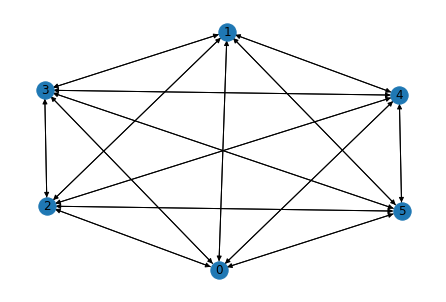

In [12]:
# Load the dgl graphs & draw:
## 1) Lollipop Graph
dgl_lollipop_graph = remove_self_loop(MiniGCDataset(8, 7, 8)[3][0])
plt.figure(1)
nx.draw(dgl_lollipop_graph.to_networkx(), with_labels=True)

## 2) Hypercube Graph
dgl_hypercube_graph = remove_self_loop(MiniGCDataset(8, 8, 9)[4][0])
plt.figure(2)
nx.draw(dgl_hypercube_graph.to_networkx(), with_labels=True)

## 3) Clique Graph
dgl_clique_graph = remove_self_loop(MiniGCDataset(8, 6, 7)[6][0])
plt.figure(3)
nx.draw(dgl_clique_graph.to_networkx(), with_labels=True)

lollipop = "Lollipop"
hypercube = "Hypercube"
clique = "Clique"

# Delete the graphs from ArangoDB if they already exist
db.delete_graph(lollipop, drop_collections=True, ignore_missing=True)
db.delete_graph(hypercube, drop_collections=True, ignore_missing=True)
db.delete_graph(clique, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graphs
adb_lollipop_graph = adbdgl_adapter.dgl_to_arangodb(lollipop, dgl_lollipop_graph)
adb_hypercube_graph = adbdgl_adapter.dgl_to_arangodb(hypercube, dgl_hypercube_graph)
adb_clique_graph = adbdgl_adapter.dgl_to_arangodb(clique, dgl_clique_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print("View the created graphs here:\n")
print(f"1) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{lollipop}")
print(f"2) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{hypercube}")
print(f"3) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{clique}\n")
print(f"View the original graphs below:\n")


#### MiniGCDataset Graphs with attributes

Data source
* [DGL Mini Graph Classification Dataset](https://docs.dgl.ai/en/0.6.x/api/python/dgl.data.html#mini-graph-classification-dataset)

Package methods used
* [`adbdgl_adapter.adapter.dgl_to_arangodb()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/adapter.py#L215-L311)
* [`adbdgl_adapter.controller._dgl_feature_to_adb_attribute()`](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/controller.py#L49-L70)

Important notes
* The `name` parameters in this case are simply for naming your ArangoDB graph.
* We are creating a custom `ADBDGL_Controller` to specify *how* to convert our DGL node/edge features into ArangoDB vertex/edge attributes. View the default `ADBDGL_Controller` [here](https://github.com/arangoml/dgl-adapter/blob/2.0.0/adbdgl_adapter/controller.py#L11).

In [13]:
# Load the dgl graphs
dgl_lollipop_graph = remove_self_loop(MiniGCDataset(8, 7, 8)[3][0])
dgl_hypercube_graph = remove_self_loop(MiniGCDataset(8, 8, 9)[4][0])
dgl_clique_graph = remove_self_loop(MiniGCDataset(8, 6, 7)[6][0])

 # Add DGL Node & Edge Features to each graph
dgl_lollipop_graph.ndata["random_ndata"] = torch.tensor(
    [[i, i, i] for i in range(0, dgl_lollipop_graph.num_nodes())]
)
dgl_lollipop_graph.edata["random_edata"] = torch.rand(dgl_lollipop_graph.num_edges())

dgl_hypercube_graph.ndata["random_ndata"] = torch.rand(dgl_hypercube_graph.num_nodes())
dgl_hypercube_graph.edata["random_edata"] = torch.tensor(
    [[[i], [i], [i]] for i in range(0, dgl_hypercube_graph.num_edges())]
)

dgl_clique_graph.ndata['clique_ndata'] = torch.tensor([1,2,3,4,5,6])
dgl_clique_graph.edata['clique_edata'] = torch.tensor(
    [1 if i % 2 == 0 else 0 for i in range(0, dgl_clique_graph.num_edges())]
)

# A user-defined Controller class is OPTIONAL when converting DGL features
# to ArangoDB attributes. NOTE: A custom Controller is NOT needed if you want to
# keep the numerical-based values of your DGL features.
class Clique_ADBDGL_Controller(ADBDGL_Controller):
    """ArangoDB-DGL controller.

    Responsible for controlling how ArangoDB attributes
    are converted into DGL features, and vice-versa.

    You can derive your own custom ADBDGL_Controller if you want to maintain
    consistency between your ArangoDB attributes & your DGL features.
    """

    def _dgl_feature_to_adb_attribute(self, key: str, col: str, val: Tensor):
        """
        Given a DGL feature key, its assigned value (for an arbitrary node or edge),
        and the collection it belongs to, convert it to a valid ArangoDB attribute
        (e.g string, list, number, ...).

        NOTE: No action is needed here if you want to keep the numerical-based values
        of your DGL features.

        :param key: The DGL attribute key name
        :type key: str
        :param col: The ArangoDB collection of the (soon-to-be) ArangoDB document.
        :type col: str
        :param val: The assigned attribute value of the DGL node.
        :type val: Tensor
        :return: The feature's representation as an ArangoDB Attribute
        :rtype: Any
        """

        if key == "clique_ndata":
          try:
            return ["Eins", "Zwei", "Drei", "Vier", "Fünf", "Sechs"][key-1]
          except:
            return -1

        if key == "clique_edata":
          return bool(val)

        return super()._dgl_feature_to_adb_attribute(key, col, val)

# Re-instantiate a new adapter specifically for the Clique Graph Conversion
clique_adbgl_adapter = ADBDGL_Adapter(db, Clique_ADBDGL_Controller())

# Create the ArangoDB graphs
lollipop = "Lollipop_With_Attributes"
hypercube = "Hypercube_With_Attributes"
clique = "Clique_With_Attributes"

db.delete_graph(lollipop, drop_collections=True, ignore_missing=True)
db.delete_graph(hypercube, drop_collections=True, ignore_missing=True)
db.delete_graph(clique, drop_collections=True, ignore_missing=True)

adb_lollipop_graph = adbdgl_adapter.dgl_to_arangodb(lollipop, dgl_lollipop_graph)
adb_hypercube_graph = adbdgl_adapter.dgl_to_arangodb(hypercube, dgl_hypercube_graph)
adb_clique_graph = clique_adbgl_adapter.dgl_to_arangodb(clique, dgl_clique_graph) # Notice the new adapter here!

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print("View the created graphs here:\n")
print(f"1) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{lollipop}")
print(f"2) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{hypercube}")
print(f"3) {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{clique}\n")

[2022/05/25 17:25:16 +0000] [60] [INFO] - adbdgl_adapter: Instantiated ADBDGL_Adapter with database 'TUT56z6dbtgsoeu5cc6aixs7d'
[2022/05/25 17:25:17 +0000] [60] [INFO] - adbdgl_adapter: Created ArangoDB 'Lollipop_With_Attributes' Graph
[2022/05/25 17:25:17 +0000] [60] [INFO] - adbdgl_adapter: Created ArangoDB 'Hypercube_With_Attributes' Graph
[2022/05/25 17:25:18 +0000] [60] [INFO] - adbdgl_adapter: Created ArangoDB 'Clique_With_Attributes' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTtj3263blez70kmqdi3ts
Password: TUTf6tursgxqogdo3ww3nplb
Database: TUT56z6dbtgsoeu5cc6aixs7d
--------------------

\View the created graphs here:

1) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Lollipop_With_Attributes
2) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Hypercube_With_Attributes
3) https://tutorials.arangodb.cloud:8529/_db/TUT56z6dbtgsoeu5cc6aixs7d/_admin/aardvark/index.html#graph/Clique_With_Attributes

